In [1]:
print("working")

working


## Imports

In [2]:
# Core
from __future__ import absolute_import, division, print_function, unicode_literals

# Libraries
import numpy as np
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plot
from IPython.display import clear_output

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

# Utils

from utils import Session




In [3]:
session = Session("TensorFlow")
spark = session.session
spark

### Datasets

In [4]:

# dftrain = spark.read.csv(
#     'https://storage.googleapis.com/tf-datasets/titanic/train.csv',
#     inferSchema = True,
#     header = True) # training data
# dfeval = spark.read.csv(
#     'https://storage.googleapis.com/tf-datasets/titanic/eval.csv',
#     inferSchema = True,
#     header = True) # testing data

spark.sparkContext.addFile("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
spark.sparkContext.addFile("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")


dftrain = spark.read.csv(
    ps.SparkFiles.get("train.csv"), header = True, inferSchema=True
)

dfeval = spark.read.csv(
    ps.SparkFiles.get("eval.csv"), header = True, inferSchema=True
)

In [5]:
dftrain.limit(5).toPandas()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dfeval.limit(5).toPandas()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [7]:
print(dftrain.printSchema(), dfeval.printSchema(), sep = "\n")

root
 |-- survived: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- n_siblings_spouses: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- class: string (nullable = true)
 |-- deck: string (nullable = true)
 |-- embark_town: string (nullable = true)
 |-- alone: string (nullable = true)

root
 |-- survived: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- n_siblings_spouses: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- class: string (nullable = true)
 |-- deck: string (nullable = true)
 |-- embark_town: string (nullable = true)
 |-- alone: string (nullable = true)

None
None


In [8]:
# Remove the labels and store them into variables.

y_label_train = dftrain.select('survived') 
y_label_eval = dfeval.select('survived')
print(y_label_train.limit(5).toPandas(), y_label_eval.limit(5).toPandas(), sep="\n")

dftrain = dftrain.drop('survived')
dfeval = dfeval.drop('survived')

   survived
0         0
1         1
2         1
3         1
4         0
   survived
0         0
1         0
2         1
3         1
4         1


In [9]:
print(dftrain.printSchema(), dfeval.printSchema(), sep = "\n")

root
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- n_siblings_spouses: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- class: string (nullable = true)
 |-- deck: string (nullable = true)
 |-- embark_town: string (nullable = true)
 |-- alone: string (nullable = true)

root
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- n_siblings_spouses: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- class: string (nullable = true)
 |-- deck: string (nullable = true)
 |-- embark_town: string (nullable = true)
 |-- alone: string (nullable = true)

None
None


<Axes: >

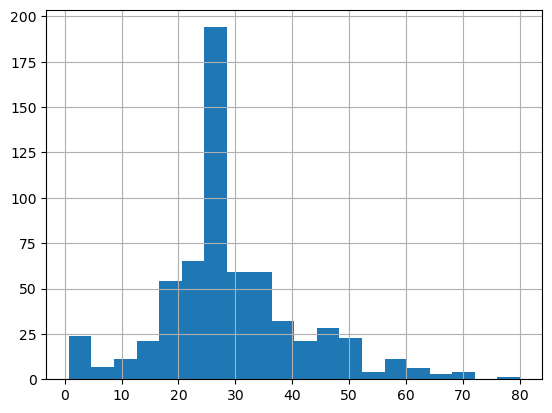

In [10]:
dftrain.toPandas().age.hist(bins=20) #bins-increments of graphing

<Axes: >

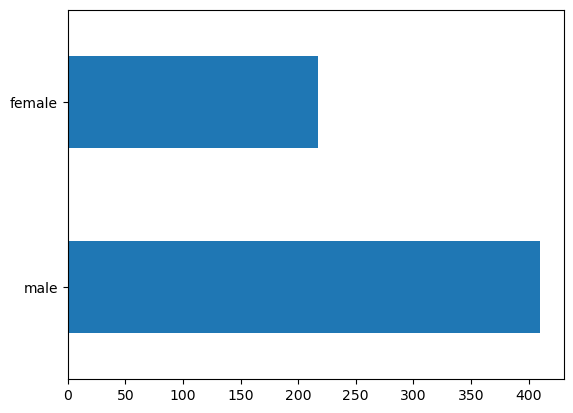

In [11]:
dftrain.toPandas().sex.value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

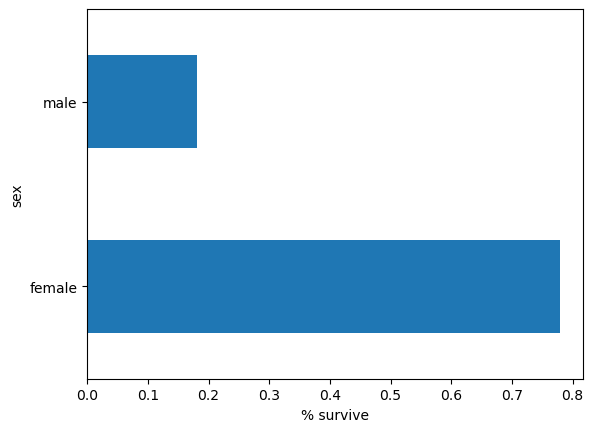

In [12]:
pd.concat([dftrain.toPandas(), y_label_train.toPandas()], axis=1)\
    .groupby('sex')\
    .survived.mean().plot(kind='barh').set_xlabel('% survive')

In [13]:
# Convert pySpark DF to Pandas DF to work easily

dftrain = dftrain.toPandas()
dfeval = dfeval.toPandas()

y_label_eval = y_label_eval.toPandas()
y_label_train = y_label_train.toPandas()

In [14]:
dftrain.head()
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int32  
 3   parch               627 non-null    int32  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int32(2), object(5)
memory usage: 39.3+ KB


In [15]:
# Categorize data
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [16]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  #Create a column of feature names with the different associated vocabulary terms
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

clear_output()

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

clear_output()

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int32, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int32, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [17]:
def make_input_fn(
    data_df, 
    label_df, 
    num_epochs=10, 
    shuffle=True, 
    batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_label_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_label_eval, num_epochs=1, shuffle=False)

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier through an estimator module

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model that tells the accuracy of it
#Accuracy - compares the dataset results with models predicted results to get the accuracy of the data
print(result)

0.7386364
{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.8348638, 'auc_precision_recall': 0.7880521, 'average_loss': 0.4859255, 'label/mean': 0.375, 'loss': 0.4812797, 'precision': 0.6388889, 'prediction/mean': 0.41663894, 'recall': 0.6969697, 'global_step': 200}


In [19]:
#Check the predictions of the model
#Here we will turn the results into a list to get a dictionary of all points and predictions
result = list(linear_est.predict(eval_input_fn))
#print(result[0])
#Here are looking for the 'probabilities' dict because it will help us to see the probability that someone will survive or won't survive
#Look for this --> {'probabilities': array([0.9108078 (<--won't survive(0)) , 0.08919217 (<-- will survive(1))]}

#Here we will print the probability of survival (1)
print(result[0]['probabilities'][0]) #Format: [passenger/data point][data set dict][outcome (survival)]

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp67po468u/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9160499


In [23]:
import time
for i in range(0, 15):
    clear_output()
    print(dfeval.loc[i])
    print(y_label_eval.loc[i])
    print(result[i]['probabilities'][1]) 
    #This will give us the passengers details and their chance of survival and if they survived
    time.sleep(3)
    

sex                        female
age                          29.0
n_siblings_spouses              0
parch                           0
fare                         10.5
class                      Second
deck                            F
embark_town           Southampton
alone                           y
Name: 14, dtype: object
survived    1
Name: 14, dtype: int32
0.84584385
